In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from  IPython.display import Audio

import torchaudio
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import Wav2Vec2Model, Wav2Vec2Processor, Trainer, TrainingArguments, Wav2Vec2ForSequenceClassification


import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import files
files.upload()  # kaggle.json upload korar jonno


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"grvcwdry","key":"b810d66d5955b96c4699eae873dae7da"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!pip install kaggle


In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!pip install kaggle


In [5]:
from google.colab import drive
drive.mount('/content/drive')




Mounted at /content/drive


In [6]:
!ls /content/drive/MyDrive/dataset


archive.zip  record1.wav


In [7]:
import zipfile

zip_path = '/content/drive/MyDrive/dataset/archive.zip'
extract_path = '/content/dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Dataset extraction complete!")



✅ Dataset extraction complete!


In [8]:
# Extracted folder e ki ache dekhar jonno
import os

data_path = '/content/dataset'
print(os.listdir(data_path))


['tess toronto emotional speech set data', 'TESS Toronto emotional speech set data']


In [9]:
paths = []
labels = []

for dirname, _, filenames in os.walk('/content/dataset'):
    for filename in filenames:
        if filename.endswith('.wav'):  # Only WAV files
            paths.append(os.path.join(dirname, filename))
            label = filename.split('_')[-1].split('.')[0]
            labels.append(label.lower())

print(f"✅ Total files: {len(paths)}")
print(f"Example Path: {paths[0]}")
print(f"Example Label: {labels[0]}")


✅ Total files: 5600
Example Path: /content/dataset/tess toronto emotional speech set data/TESS Toronto emotional speech set data/YAF_disgust/YAF_juice_disgust.wav
Example Label: disgust


In [10]:
len(paths)

5600

In [11]:
paths[:5]

['/content/dataset/tess toronto emotional speech set data/TESS Toronto emotional speech set data/YAF_disgust/YAF_juice_disgust.wav',
 '/content/dataset/tess toronto emotional speech set data/TESS Toronto emotional speech set data/YAF_disgust/YAF_keen_disgust.wav',
 '/content/dataset/tess toronto emotional speech set data/TESS Toronto emotional speech set data/YAF_disgust/YAF_mob_disgust.wav',
 '/content/dataset/tess toronto emotional speech set data/TESS Toronto emotional speech set data/YAF_disgust/YAF_should_disgust.wav',
 '/content/dataset/tess toronto emotional speech set data/TESS Toronto emotional speech set data/YAF_disgust/YAF_thought_disgust.wav']

In [12]:
labels[:5]

['disgust', 'disgust', 'disgust', 'disgust', 'disgust']

In [13]:
## Create a dataframe
import pandas as pd

df = pd.DataFrame()
df['audio_paths'] = paths
df['labels'] = labels
df.head()


,audio_paths,labels
0,/content/dataset/tess toronto emotional speech...,disgust
1,/content/dataset/tess toronto emotional speech...,disgust
2,/content/dataset/tess toronto emotional speech...,disgust
3,/content/dataset/tess toronto emotional speech...,disgust
4,/content/dataset/tess toronto emotional speech...,disgust


In [14]:
# Labels-er distribution dekhar jonno
df['labels'].value_counts()


,count
labels,
disgust,800
sad,800
angry,800
neutral,800
happy,800
fear,800
ps,800


<Axes: xlabel='labels', ylabel='count'>

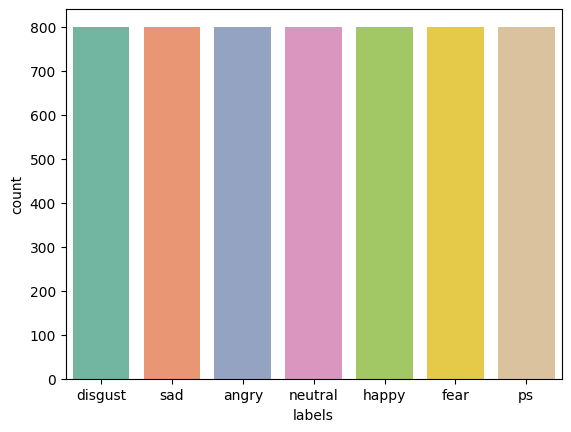

In [15]:
sns.countplot(data=df, x='labels', palette='Set2')



In [16]:
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10, 4))
    plt.title(emotion, size=20)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def spectrogram(data, sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11, 4))
    plt.title(emotion, size=20)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()


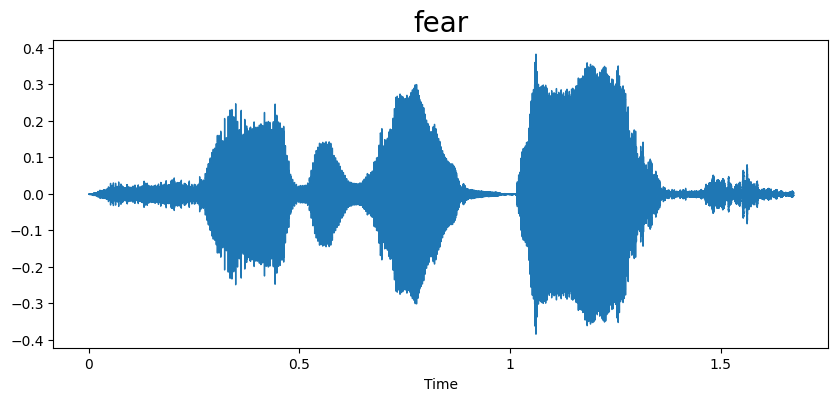

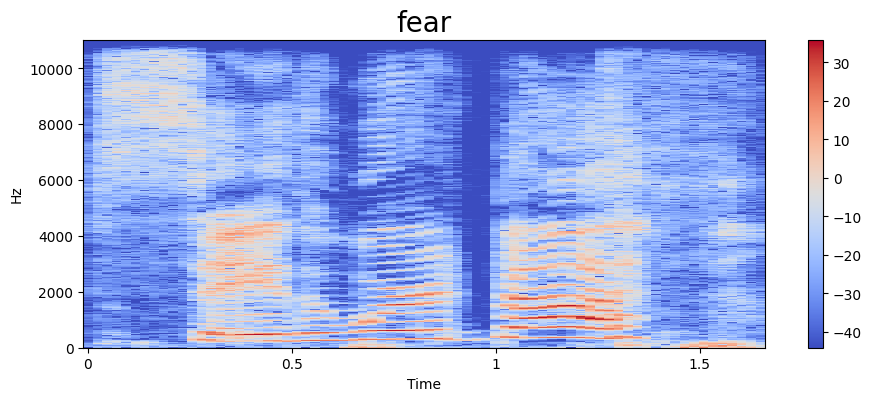

In [17]:
emotion = 'fear'
path = np.array(df['audio_paths'][df['labels'] == emotion])[0]
data, sampling_rate = librosa.load(path)

waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)

Audio(path)


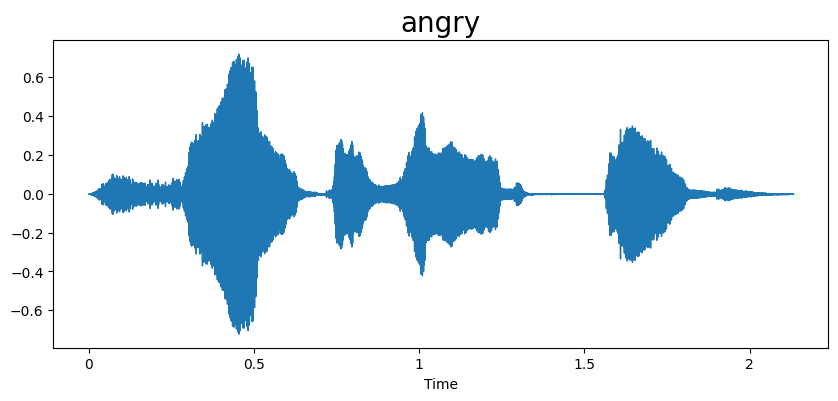

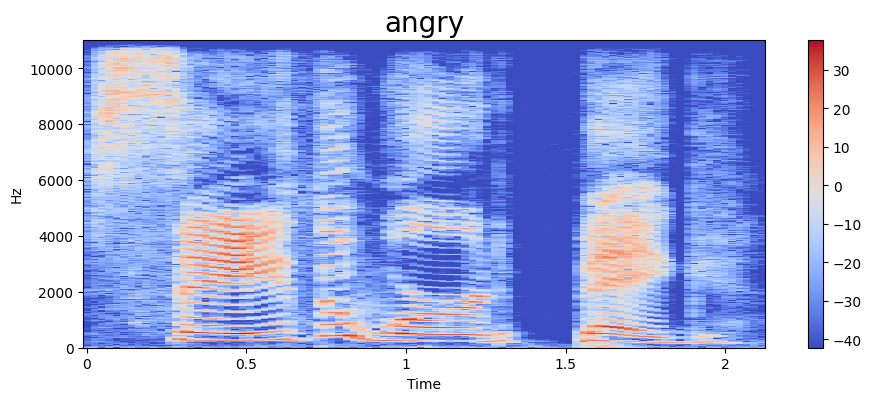

In [18]:
emotion = 'angry'
path = np.array(df['audio_paths'][df['labels'] == emotion])[1]
data, sampling_rate = librosa.load(path)

waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)

Audio(path)


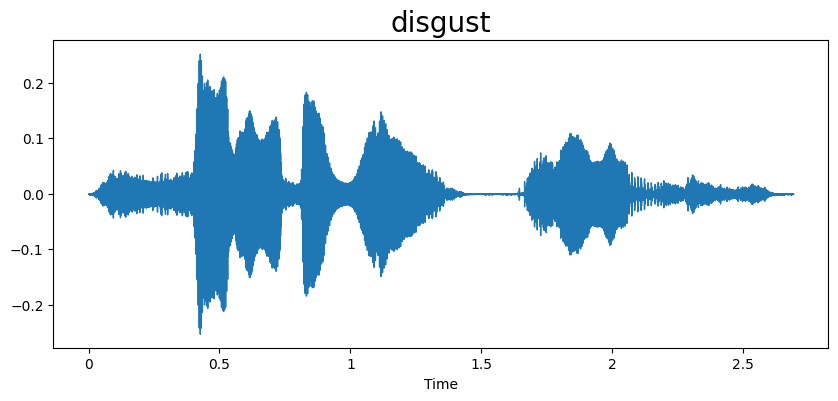

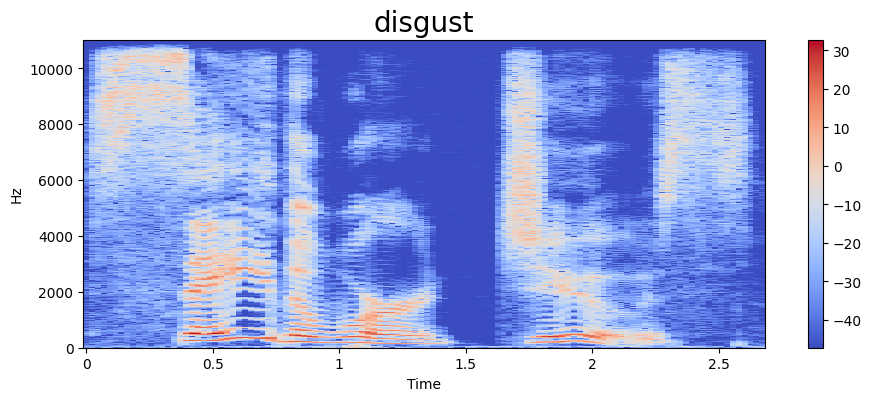

In [19]:
emotion = 'disgust'
path = np.array(df['audio_paths'][df['labels'] == emotion])[0]
data, sampling_rate = librosa.load(path)

waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)

Audio(path)


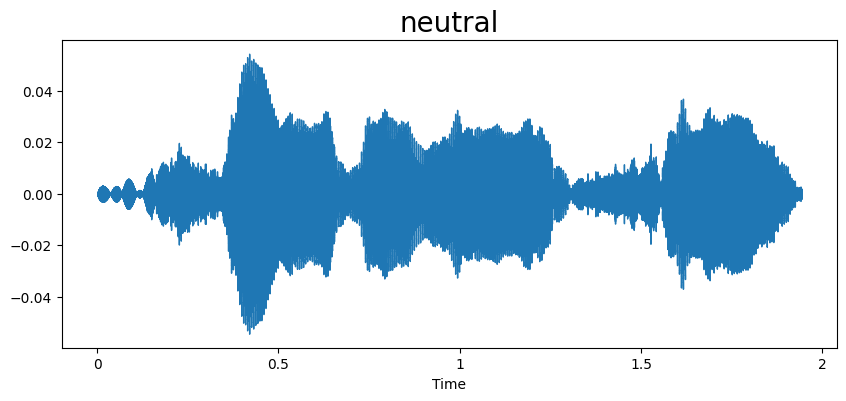

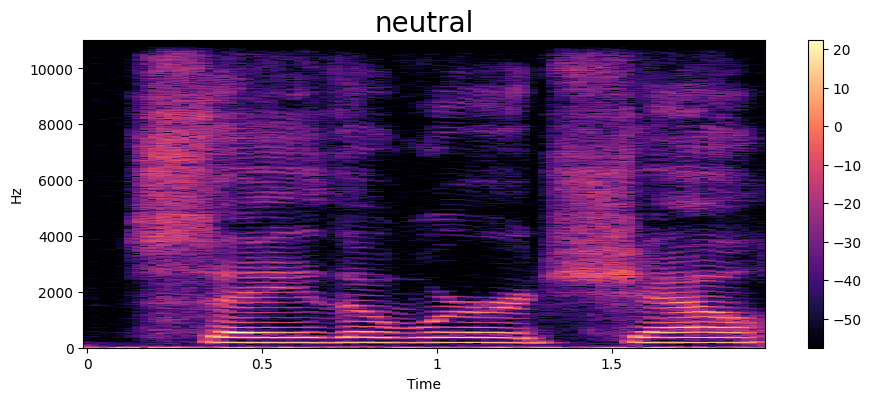

In [20]:
emotion = 'neutral'

path = np.array(df['audio_paths'][df['labels'] == emotion])[0]

data, sampling_rate = librosa.load(path)

waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)

Audio(path)


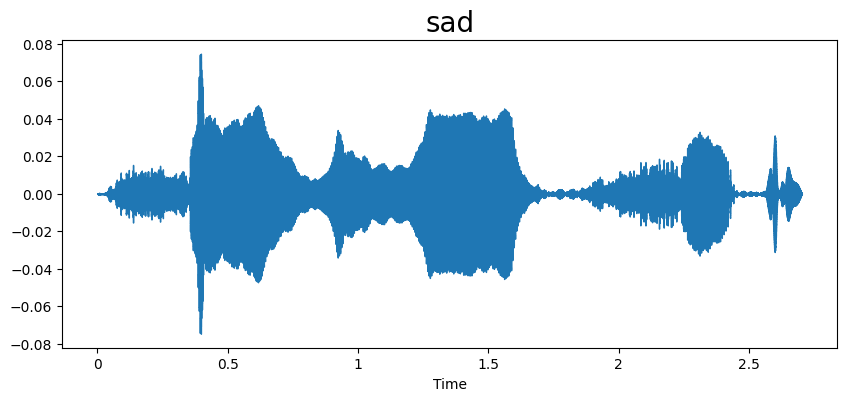

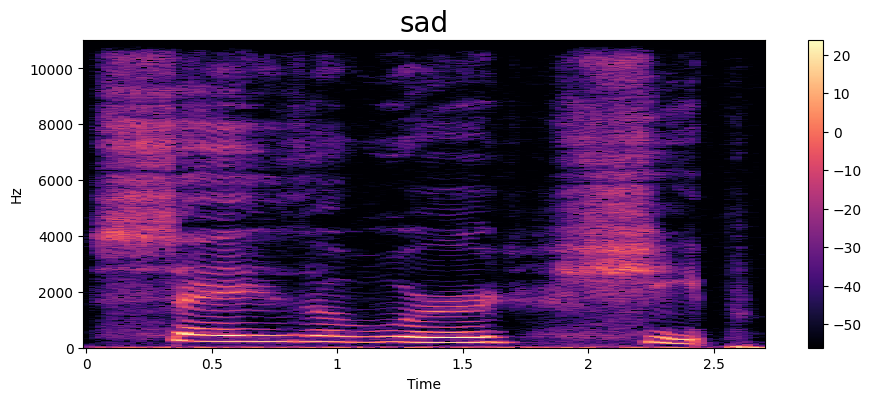

In [21]:
emotion = 'sad'
path = np.array(df['audio_paths'][df['labels'] == emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)
Audio(path)



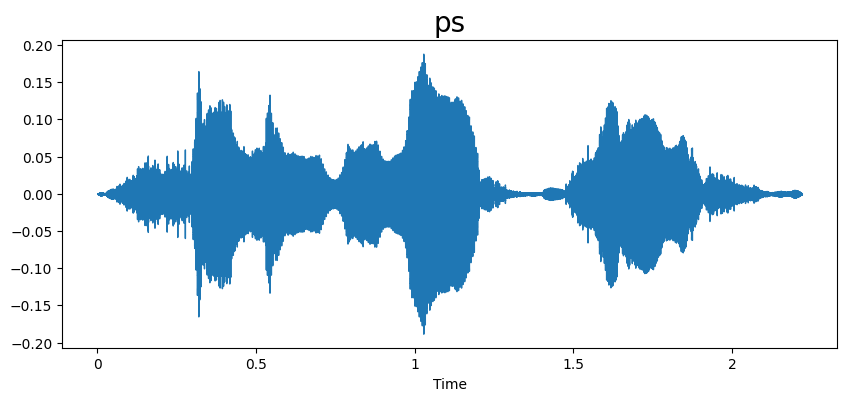

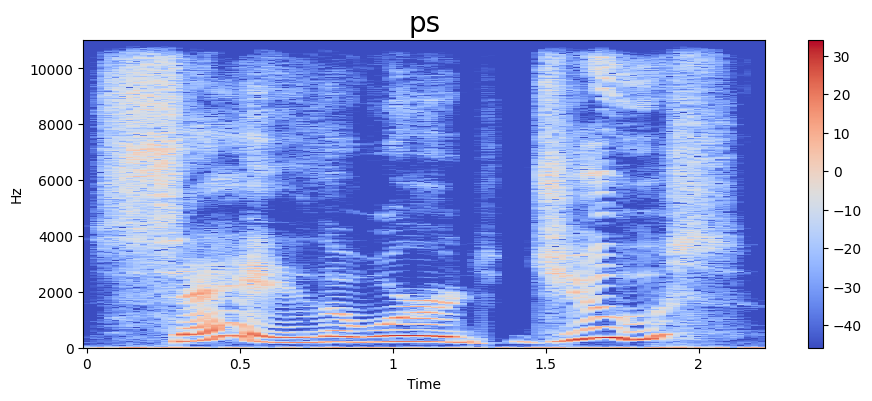

In [22]:
emotion = 'ps'
path = np.array(df['audio_paths'][df['labels'] == emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)
Audio(path)


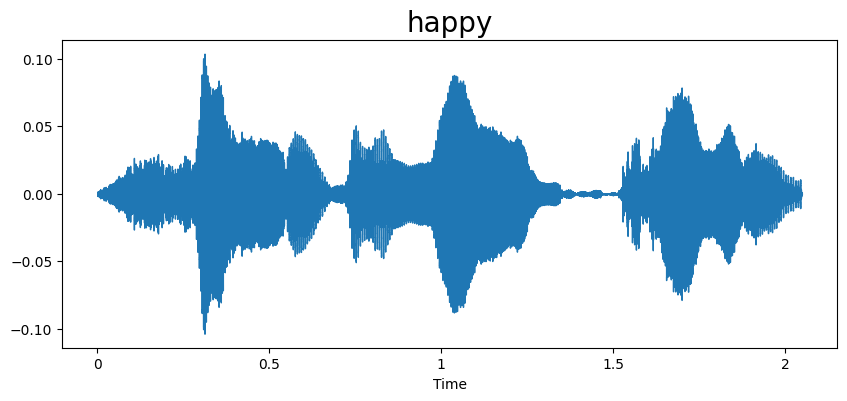

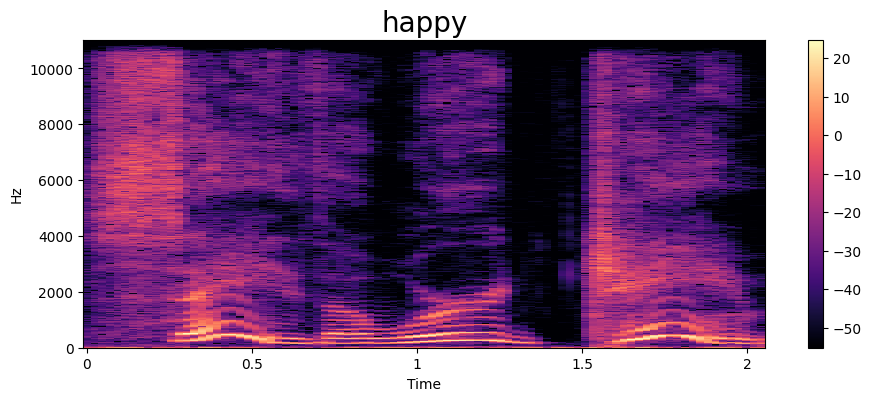

In [23]:
emotion = 'happy'
path = np.array(df['audio_paths'][df['labels'] == emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectrogram(data, sampling_rate, emotion)
Audio(path)


In [24]:
# Convert labels to integers
label_map = {label: idx for idx, label in enumerate(df['labels'].unique())}
inverse_label_map = {idx: label for label, idx in label_map.items()}
df['labels'] = df['labels'].map(label_map)
df.head(2)


,audio_paths,labels
0,/content/dataset/tess toronto emotional speech...,0
1,/content/dataset/tess toronto emotional speech...,0


In [25]:
class SpeechEmotionDataset(Dataset):
    def __init__(self, df, processor, max_length=32000):
        self.df = df
        self.processor = processor
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
      audio_path = self.df.iloc[idx]['audio_paths']
      label = self.df.iloc[idx]['labels']

      # Load the audio file
      speech,sr = librosa.load(audio_path, sr=16000)

      # Pad or truncate the speech to the required length
      if len(speech) > self.max_length:
          speech = speech[:self.max_length]
      else:
          speech = np.pad(speech, (0, self.max_length - len(speech)), 'constant')

      # Preprocess the audio file using the provided processor
      inputs = self.processor(
          speech,
          sampling_rate=16000,  # Ensure consistent sampling rate
          return_tensors='pt',
          padding=True,
          truncation=True,
          max_length=self.max_length
      )

      # Ensure correct shape of input values
      input_values = inputs.input_values.squeeze(0)

      return {'input_values': input_values, 'labels': torch.tensor(label, dtype=torch.long)}



In [26]:
# split the data for train and test
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)


In [27]:
# initialize the processor and model
processor = Wav2Vec2Processor.from_pretrained('facebook/wav2vec2-base')
model = Wav2Vec2ForSequenceClassification.from_pretrained(
    'facebook/wav2vec2-base', num_labels=7
)


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.84k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
# load the dataset
train_dataset = SpeechEmotionDataset(train_df, processor)
test_dataset = SpeechEmotionDataset(test_df, processor)


In [29]:
train_dataset[0]['input_values'].size()


torch.Size([32000])

In [30]:
# create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)


In [31]:
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    report_to=[]
)


In [32]:
# create functions for computing metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids  # original labels
    preds = np.argmax(pred.predictions, axis=1)  # model predicted labels
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }


In [33]:
# initialize the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.116017,1.000000,1.000000,1.000000,1.000000
2,0.482700,0.038310,1.000000,1.000000,1.000000,1.000000
3,0.482700,0.028884,1.000000,1.000000,1.000000,1.000000


TrainOutput(global_step=840, training_loss=0.30360624563126337, metrics={'train_runtime': 648.4037, 'train_samples_per_second': 20.728, 'train_steps_per_second': 1.295, 'total_flos': 2.4403696128e+17, 'train_loss': 0.30360624563126337, 'epoch': 3.0})

In [34]:
results = trainer.evaluate()
print(results)


{'eval_loss': 0.02888440154492855, 'eval_accuracy': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': 12.6168, 'eval_samples_per_second': 88.77, 'eval_steps_per_second': 5.548, 'epoch': 3.0}


In [35]:
torch.save(model.state_dict(), 'emotion_model.pth')


In [84]:
import os
print("Current Directory:", os.getcwd())
print("Files in Directory:", os.listdir())


Current Directory: /content
Files in Directory: ['.config', 'results', 'emotion_model.pth', 'drive', 'saved_model', 'kaggle.json', 'dataset', 'sample_data']


In [112]:
import torchaudio.transforms as transforms

def predict_emotion(model, wav_path, processor, inverse_label_map, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    Predicts the emotion from an audio file using a trained model.
    """
    try:
        if not os.path.exists(wav_path):
            raise FileNotFoundError(f"Error: File '{wav_path}' not found!")

        model.to(device)
        model.eval()

        #  Load audio file
        waveform, sample_rate = torchaudio.load(wav_path)
        print(f"✅ Audio Loaded: {wav_path} | Sample Rate: {sample_rate} | Shape: {waveform.shape}")

        #  Resample to 16,000 Hz if needed
        target_sample_rate = 16000
        if sample_rate != target_sample_rate:
            print(f"⚠️ Resampling from {sample_rate} Hz to {target_sample_rate} Hz...")
            resampler = transforms.Resample(orig_freq=sample_rate, new_freq=target_sample_rate)
            waveform = resampler(waveform)

        #  Process the audio
        inputs = processor(
            waveform.squeeze().numpy(),
            sampling_rate=target_sample_rate,
            return_tensors="pt",
            padding=True
        )
        input_values = inputs.input_values.to(device).float()

        #  Perform inference
        with torch.no_grad():
            outputs = model(input_values)
            predicted_class = outputs.logits.argmax(dim=1).item()

        #  Get the predicted emotion label
        predicted_label = inverse_label_map.get(predicted_class, "Unknown")
        print(f"🎭 Predicted Emotion: {predicted_label}")

        return predicted_label

    except Exception as e:
        print(f"❌ Error: {e}")
        return "Error"

#  Test Again
file_path = "/content/drive/MyDrive/dataset/record6.wav"
predict_emotion(model, file_path, processor, inverse_label_map)


✅ Audio Loaded: /content/drive/MyDrive/dataset/record6.wav | Sample Rate: 16000 | Shape: torch.Size([1, 58368])
🎭 Predicted Emotion: disgust


'disgust'

In [114]:
predict_emotion(model, "/content/drive/MyDrive/dataset/record6.wav", processor, inverse_label_map)


✅ Audio Loaded: /content/drive/MyDrive/dataset/record6.wav | Sample Rate: 16000 | Shape: torch.Size([1, 58368])
🎭 Predicted Emotion: disgust


'disgust'